In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# データをインポートしてDataFrameの内容とデータ型、欠損の確認をする
from sklearn.datasets import fetch_california_housing
california_housing_data = fetch_california_housing()
# 目的変数
tar_data = pd.DataFrame(california_housing_data.target, columns=['HousingPrices'])
# 説明変数
exp_data = pd.DataFrame(california_housing_data.data, columns=california_housing_data.feature_names)
# データを結合
data = pd.concat([exp_data, tar_data], axis=1)

<Axes: >

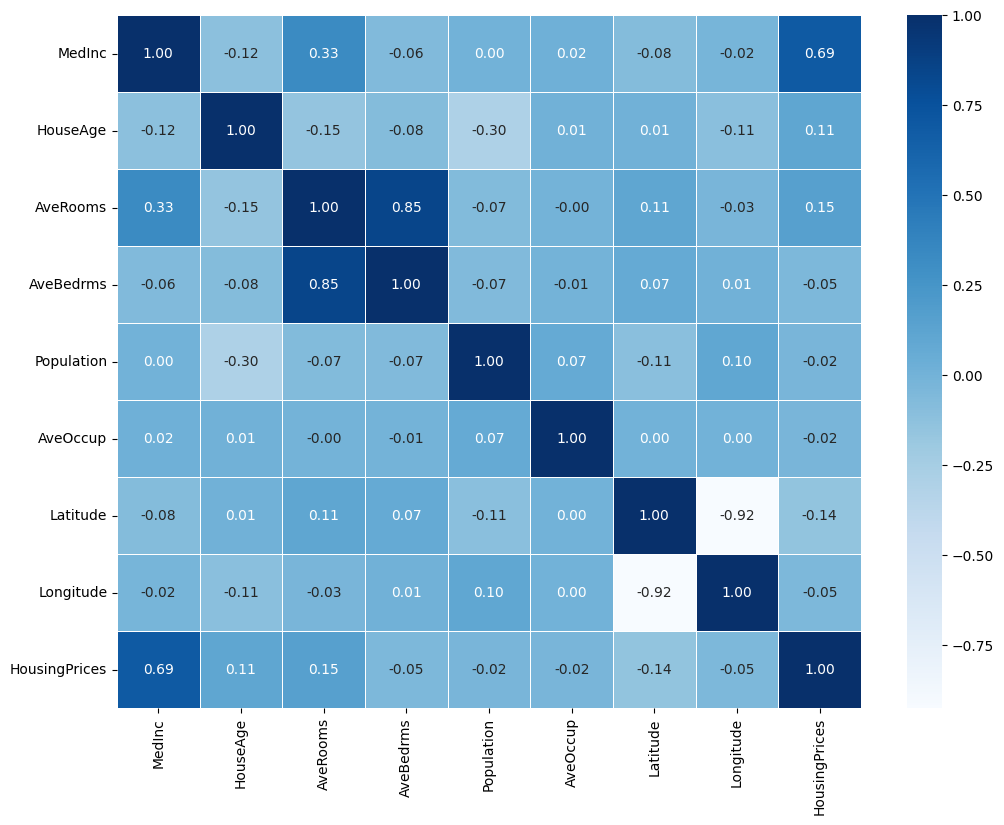

In [4]:
# ヒートマップを表示
plt.figure(figsize=(12, 9))
sns.heatmap(data.corr(), annot=True, cmap='Blues', fmt='.2f', linewidths=.5)

In [5]:
# 重回帰分析を行っていくが, 全てを説明変数とはしたくないので効果的なものを選ぶ。
# HousingPricesと比較的相関係数の大きなものはHouseAge, AveRooms, Latitudeなので, これらを説明変数とする.
# Longitudeが低いのはカリフォルニアが縦長な州だからだと想像できる. おそらくLatitudeはサンフランからサンノゼ方向に延びるシリコンバレーとロスの辺りが高い.
# AveBedrmsの相関係数が低いのが意外だが, AveBedrmsはAveRooomsと相関性が高いので, AveRoomsが説明変数に入っていれば十分だと予想.
# Populationが低いのは意外. 人口が極小の田舎と大都市で住宅価格は大きな差があるように思える. 確認が必要.
# AveOccupが低いのも意外. AveOccupは他の値全てと相関性が無さそう. もしかしてかなり一定なのか. こちらも確認が必要.
data[['Population', 'AveOccup']].describe()

,Population,AveOccup
count,20640.000000,20640.000000
mean,1425.476744,3.070655
std,1132.462122,10.386050
min,3.000000,0.692308
25%,787.000000,2.429741
50%,1166.000000,2.818116
75%,1725.000000,3.282261
max,35682.000000,1243.333333


In [6]:
# 外れ値半端じゃなさそう。
# 1パーセンタイル以下と99パーセンタイル以上を除外してみる

# Populationを絞り込む
q_1 = data['Population'].quantile(0.01)
q_99 = data['Population'].quantile(0.99)
data = data[q_1 < data['Population']]
data = data[data['Population'] < q_99]

# AveOccupを絞り込む
q_1 = data['AveOccup'].quantile(0.01)
q_99 = data['AveOccup'].quantile(0.99)
data = data[q_1 < data['AveOccup']]
data = data[data['AveOccup'] < q_99]

# 統計情報を表示
data[['Population', 'AveOccup']].describe()

,Population,AveOccup
count,19817.000000,19817.000000
mean,1372.172630,2.903654
std,859.254575,0.676939
min,89.000000,1.541284
25%,799.000000,2.439331
50%,1167.000000,2.817664
75%,1705.000000,3.267930
max,5804.000000,5.313830


<Axes: >

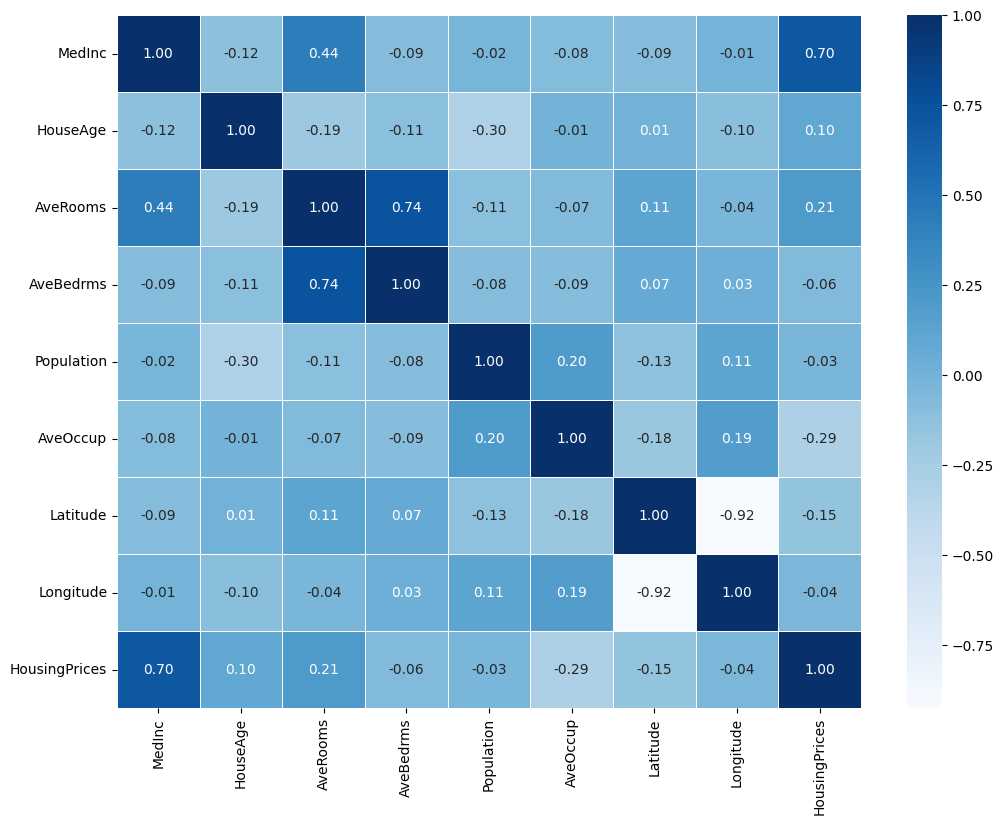

In [7]:
# かなりマシなデータになったので再度ヒートマップを表示
plt.figure(figsize=(12, 9))
sns.heatmap(data.corr(), annot=True, cmap='Blues', fmt='.2f', linewidths=.5)

In [8]:
# AveOccupは相関係数がそれっぽくなったので説明変数としてよさそう
# Populationは全然変わってないのでもはや除外した方がいいことが分かった（もしかして土地の価格は含まれずに建屋部分の価格だけだったりする？）
# 他の値も外れ値がひどく無いか確認する
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HousingPrices
count,19817.000000,19817.000000,19817.000000,19817.000000,19817.000000,19817.000000,19817.000000,19817.000000,19817.000000
mean,3.882448,28.789575,5.411329,1.087328,1372.172630,2.903654,35.640070,-119.578151,2.069917
std,1.887854,12.473348,1.873678,0.306914,859.254575,0.676939,2.137554,2.003196,1.151126
min,0.499900,1.000000,0.888889,0.500000,89.000000,1.541284,32.540000,-124.350000,0.149990
25%,2.573500,18.000000,4.471328,1.005882,799.000000,2.439331,33.940000,-121.800000,1.194000
50%,3.548100,29.000000,5.244681,1.048309,1167.000000,2.817664,34.260000,-118.510000,1.804000
75%,4.763000,37.000000,6.057692,1.098493,1705.000000,3.267930,37.720000,-118.020000,2.650000
max,15.000100,52.000000,61.812500,11.410714,5804.000000,5.313830,41.950000,-114.310000,5.000010


In [9]:
# HouseAge, Latitude, Longitudeは問題なさそう
# AveRoomsとAveBedrmsは豪邸が外れ値になってそうなので少し除外したい（中央値と平均値の差が小さいのでおそらく外れ値はあまり多くはないと予想）
# 単回帰分析の時はMedIncとHousingPricesの外れ値を除外していたが、一旦そこは操作せずに見てみる

# Populationで絞ってしまったので一度元データに戻す
data = pd.concat([exp_data, tar_data], axis=1)

# AveOccupの1パーセンタイル以下と99パーセンタイル以上を除外
q_1 = data['AveOccup'].quantile(0.01)
q_99 = data['AveOccup'].quantile(0.99)
data = data[q_1 < data['AveOccup']]
data = data[data['AveOccup'] < q_99]

# AveRoomsの99パーセンタイル以上を除外（AveBedrmsの外れ値は一緒に除外されることを期待して操作せずに見てみる）
q_99 = data['AveRooms'].quantile(0.99)
data = data[data['AveRooms'] < q_99]

# 統計情報を確認
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HousingPrices
count,20023.000000,20023.000000,20023.000000,20023.000000,20023.000000,20023.000000,20023.000000,20023.000000,20023.000000
mean,3.884645,28.735055,5.301233,1.066379,1432.136543,2.909007,35.628150,-119.579915,2.071076
std,1.892537,12.555197,1.226180,0.129569,1099.025404,0.682236,2.130957,2.004055,1.150043
min,0.499900,1.000000,0.846154,0.333333,5.000000,1.536814,32.540000,-124.350000,0.149990
25%,2.570700,18.000000,4.460519,1.005376,800.000000,2.442870,33.930000,-121.810000,1.198000
50%,3.550700,29.000000,5.234201,1.047619,1174.000000,2.824281,34.260000,-118.500000,1.809000
75%,4.772900,37.000000,6.034888,1.096883,1728.000000,3.275000,37.710000,-118.010000,2.653000
max,15.000100,52.000000,10.352941,3.411111,28566.000000,5.392954,41.950000,-114.550000,5.000010


Text(0, 0.5, 'HousingPrices')

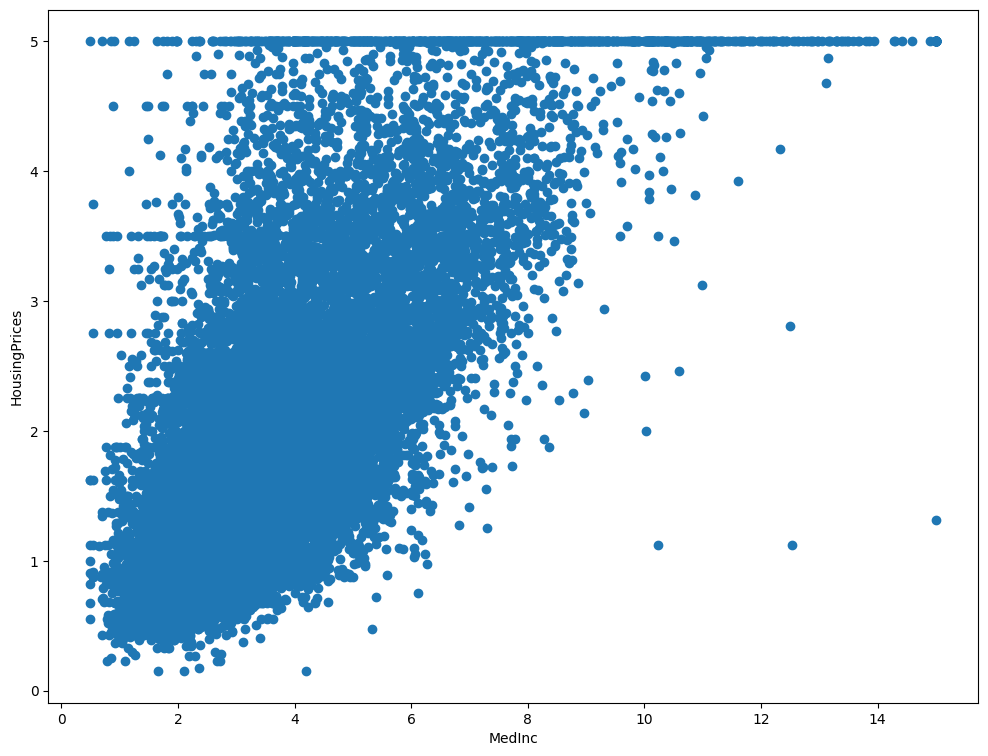

In [10]:
# 期待通りAveBedrmsの外れ値はAveRoomsと一緒に除外された
# MedInc, HousingPricesも少しましになっているが, 一応散布図を見てみる
plt.figure(figsize=(12, 9))
plt.scatter(data['MedInc'], data['HousingPrices'])
plt.xlabel('MedInc')
plt.ylabel('HousingPrices')

Text(0, 0.5, 'HousingPrices')

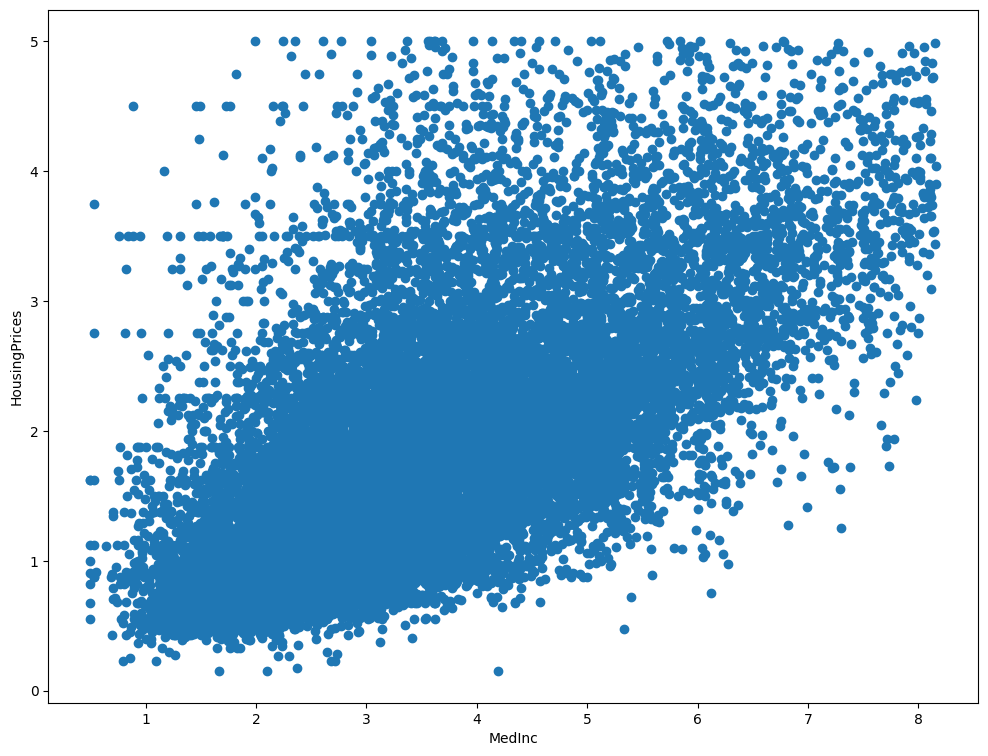

In [11]:
# ダメそうなのでどちらも99パーセンタイル以上を除外
q_99 = data['HousingPrices'].quantile(0.99)
data = data[data['HousingPrices'] < q_99]
q_99 = data['MedInc'].quantile(0.99)
data = data[data['MedInc'] < q_99]

# 散布図を表示
plt.figure(figsize=(12, 9))
plt.scatter(data['MedInc'], data['HousingPrices'])
plt.xlabel('MedInc')
plt.ylabel('HousingPrices')

<Axes: >

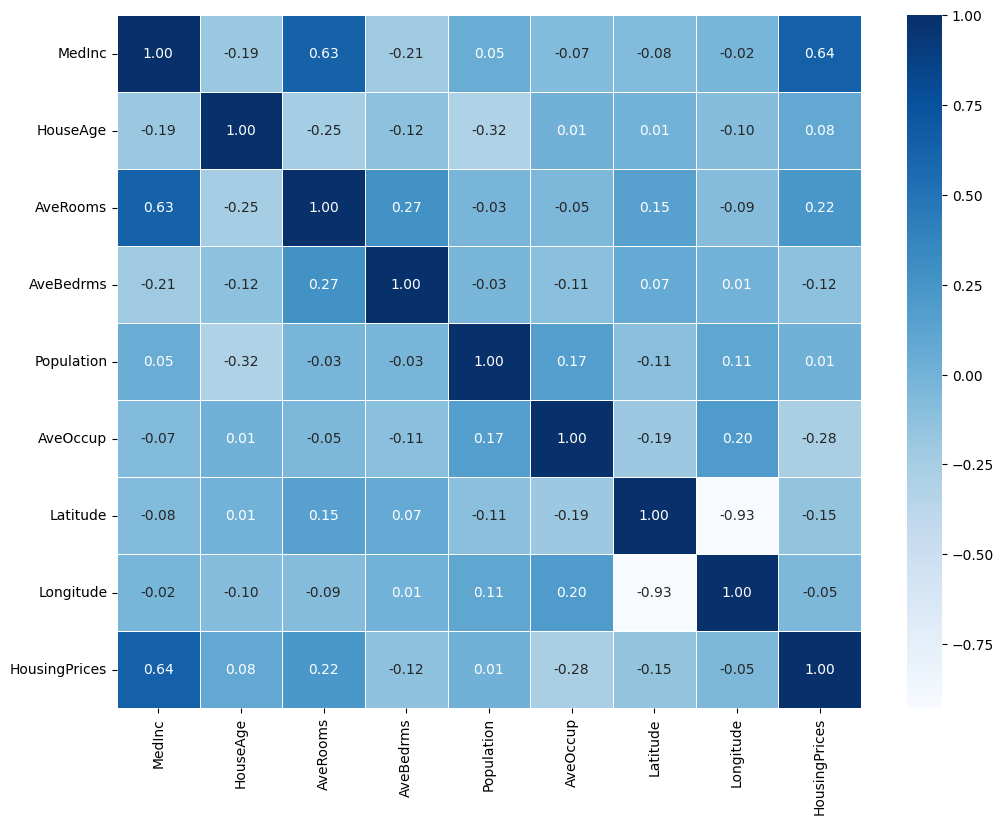

In [12]:
# 外れ値を除外した最終的なデータの相関係数を確認する
plt.figure(figsize=(12, 9))
sns.heatmap(data.corr(), annot=True, cmap='Blues', fmt='.2f', linewidths=.5)

In [13]:
# HouseAgeの相関係数下がっちゃった. 意外過ぎる. なんでや. 築年数大事やろ.
# 統計情報も見てみる
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HousingPrices
count,18916.000000,18916.000000,18916.000000,18916.000000,18916.000000,18916.000000,18916.000000,18916.000000,18916.000000
mean,3.634657,28.584056,5.209029,1.066991,1448.296627,2.927080,35.654099,-119.578906,1.910649
std,1.467839,12.464084,1.147413,0.130762,1108.404733,0.685749,2.146251,2.007710,0.958661
min,0.499900,1.000000,0.846154,0.333333,5.000000,1.536814,32.540000,-124.350000,0.149990
25%,2.526600,18.000000,4.421542,1.005739,810.000000,2.454387,33.940000,-121.780000,1.161000
50%,3.446150,29.000000,5.173527,1.047949,1188.000000,2.838825,34.270000,-118.520000,1.737000
75%,4.562500,37.000000,5.936169,1.097283,1751.000000,3.296626,37.720000,-118.010000,2.467000
max,8.158600,52.000000,10.352941,3.411111,28566.000000,5.392954,41.950000,-114.550000,5.000000


data_scaled (18916, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HousingPrices
0,2.468146,1.878723,2.683592,0.049371,-0.859182,-0.182026,1.023160,-1.325472,1.679836
1,1.368336,1.878723,0.530183,0.046411,-0.803245,-0.552892,1.023160,-1.330453,1.567176
2,0.144123,1.878723,0.935019,0.107759,-0.796929,-1.087327,1.023160,-1.330453,1.576564
3,0.273977,1.878723,-0.389906,0.280182,-0.934067,-1.147949,1.023160,-1.330453,0.820281
4,0.016653,1.878723,-0.241526,-0.884290,-0.319654,-1.164708,1.018501,-1.330453,1.128010


<Axes: >

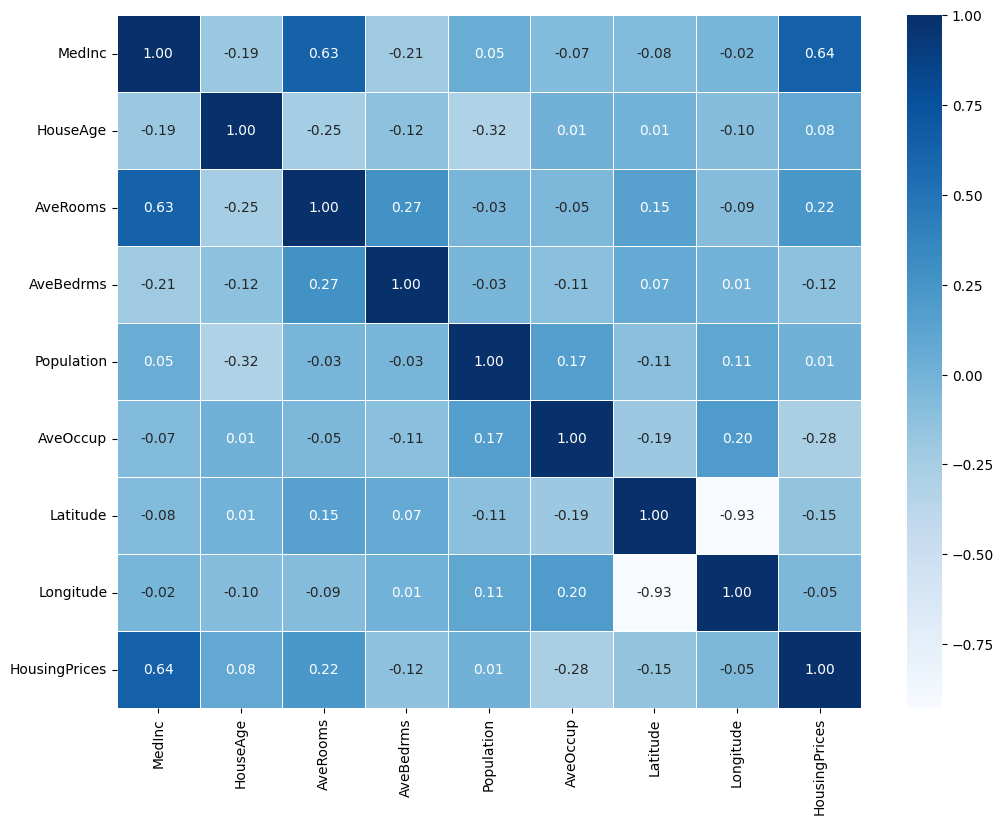

In [17]:
# 特にHouseAgeのデータに不審な点は見受けられない.

# 標準化してから相関係数を求めてみる
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data)
data_scaled = scaler.transform(data)
print('data_scaled', data_scaled.shape)
data_scaled = pd.DataFrame(data_scaled, columns = data.keys())
display(data_scaled.head())

plt.figure(figsize=(12, 9))
sns.heatmap(data_scaled.corr(), annot=True, cmap='Blues', fmt='.2f', linewidths=.5)

In [ ]:
# 標準化前と全く変わらない（変わらない気がしたからChatGPTに聞いてみて変わるって言うから試したのに。。）
# 相関係数と標準化について調べる

# 偏差：各データの平均値からの差.
# 分散：偏差の2乗の平均（2乗する理由は、偏差の平均は必ず0になってしまうから）.
# 標準偏差：分散の平方根.
# 標準化：平均は0に、標準偏差（および分散）が1になる変換. 偏差を標準偏差で割ったもの.
# 標準化が必要な理由：各データの単位が異なるため値の大きなデータが影響を大きく与えてしまうから.
# 相関係数：n個のデータ (x1,y1),(x2,y2),⋯,(xn,yn) について, 「x と y の共分散」を「x の標準偏差と y の標準偏差の積」で割った値のこと
# 共分散：n個のデータ (x1,y1),(x2,y2),⋯,(xn,yn)について, x「xとyの偏差の積の平均」のこと

# まとめると、
#  - 分散は1つのデータの偏差の2乗の平均だが, 共分散は2つのデータの偏差の積の平均になっている
#  - 相関係数はその共分散を2つのデータの標準偏差の積で割っている
#  - つまり相関係数は計算時にデータの値ではなく偏差しか使っていないので, 標準化前後で値が変わらない

# 参考ページ
# 偏差、分散、標準偏差：https://data-viz-lab.com/standarddeviation
# 標準化：https://bellcurve.jp/statistics/course/19647.html
# 標準化が必要な理由：https://qiita.com/yShig/items/dbeb98598abcc98e1a57
# 相関係数：https://atarimae.biz/archives/7966
# 共分散：https://atarimae.biz/archives/15752

In [18]:
# データを信じてMedInc, AveRooms, AveBedrms, AveOcccup, Latitudeを説明変数にして重回帰分析をしてみる

# 説明変数
exp_vars = ['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude']
# 目的変数
tar_var = 'HousingPrices'

# 説明変数と目的変数にデータを分割
X = data[exp_vars]
print(data.shape)
display(X.head())
y = data[[tar_var]]
print(y.shape)
display(y.head())

(18916, 9)


,MedInc,AveRooms,AveBedrms,AveOccup,Latitude
2,7.2574,8.288136,1.073446,2.802260,37.85
3,5.6431,5.817352,1.073059,2.547945,37.85
4,3.8462,6.281853,1.081081,2.181467,37.85
5,4.0368,4.761658,1.103627,2.139896,37.85
6,3.6591,4.931907,0.951362,2.128405,37.84


(18916, 1)


,HousingPrices
2,3.521
3,3.413
4,3.422
5,2.697
6,2.992


In [19]:
# 訓練データとテストデータに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', len(X_test))
print('y_test', len(y_test))

X_train (15132, 5)
y_train (15132, 1)
X_test 3784
y_test 3784


In [34]:
#  X_trainを標準化する
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
print('X_train_scaled', X_train_scaled.shape)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.keys())
display(X_train_scaled.head())

X_train_scaled (15132, 5)


,MedInc,AveRooms,AveBedrms,AveOccup,Latitude
0,-0.271235,-0.807536,-0.443487,2.535751,-0.806037
1,-1.037994,-1.243120,-0.075152,-0.709466,-1.351776
2,-0.808123,-1.190849,1.474770,-1.778971,-1.337783
3,0.020367,0.690897,0.219242,0.081877,-0.544829
4,-0.684661,-0.056615,-0.297460,0.141554,1.638127


In [21]:
# TODO: ここから下深掘り

# 回帰分析について勉強する
#
# 
# 参考ページ
# 回帰分析：https://bellcurve.jp/statistics/course/#step01-027

# 学習
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [22]:
# 予測値を計算
y_pred = model.predict(X_train_scaled)
y_pred[:10]
# 偏回帰係数を計算 
for xi, wi in zip(exp_vars, model.coef_[0]):
    print('{0:7s}: {1:6.3f}'.format(xi, wi))

MedInc :  0.818
AveRooms: -0.325
AveBedrms:  0.119
AveOccup: -0.231
Latitude: -0.084


In [23]:
# 係数を降順に並び替える（係数が大きいと回帰直線に大きな影響を与えていると言える）
import numpy as np
n_list = []
for i in np.argsort(-model.coef_):
    n_list = list(i)
    for j in n_list:
        print('{0:7s}: {1:6.3f}'.format(exp_vars[j], model.coef_[0][j]))

MedInc :  0.818
AveBedrms:  0.119
Latitude: -0.084
AveOccup: -0.231
AveRooms: -0.325


In [24]:
# 精度の確認
# 決定係数
print('決定係数:{:.3f}'.format(model.score(X_train_scaled, y_train)))
from sklearn.metrics import mean_squared_error

決定係数:0.533


In [25]:
# 訓練データに対する Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, y_pred)
print("訓練データに対するMSE: {:.3f}".format(mse_train))

訓練データに対するMSE: 0.428


In [26]:
# テストデータに対する MSE
X_test_scaled = scaler.transform(X_test) # テストデータを訓練データから得られた平均と標準偏差で標準化
y_test_pred = model.predict(X_test_scaled) # テストデータに対して予測する
mse_test = mean_squared_error(y_test, y_test_pred)
print("テストデータに対するMSE: {:.3f}".format(mse_test))

テストデータに対するMSE: 0.446


/home/kento/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [27]:
# Ridge回帰
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
ridge_y_pred = ridge.predict(X_train_scaled)

In [28]:
# 偏回帰係数の確認
ridge_w = pd.DataFrame(ridge.coef_.T, index=exp_vars, columns=['Ridge'])
for xi, wi in zip(exp_vars, ridge.coef_[0]):
    print('{0:7s}: {1:6.3f}'.format(xi, wi))
print('L2ノルム: {:.3f}'.format(np.linalg.norm(ridge.coef_)))

MedInc :  0.817
AveRooms: -0.325
AveBedrms:  0.119
AveOccup: -0.231
Latitude: -0.084
L2ノルム: 0.921


In [29]:
# 訓練データに対する Mean Squared Error (MSE)
ridge_mse_train = mean_squared_error(y_train, ridge_y_pred)
print("訓練データに対するMSE: {:.3f}".format(ridge_mse_train))

訓練データに対するMSE: 0.428


In [30]:
# テストデータに対する MSE
ridge_y_test_pred = ridge.predict(X_test_scaled) # テストデータに対して予測する
ridge_mse_test = mean_squared_error(y_test, ridge_y_test_pred)
print("テストデータに対するMSE: {:.3f}".format(ridge_mse_test))

テストデータに対するMSE: 0.446


/home/kento/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [31]:
# 決定係数
print('決定係数:{:.3f}'.format(ridge.score(X_train_scaled, y_train)))
# Lasso回帰
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)
lasso.fit(X_train_scaled, y_train)
lasso_y_pred = lasso.predict(X_train_scaled)

決定係数:0.533


In [32]:
# 偏回帰係数の確認
lasso_w = pd.Series(index=exp_vars, data=lasso.coef_)
for xi, wi in zip(exp_vars, lasso.coef_): # coef_は回帰直線の傾き
    # print(f'{xi, wi}')
    print('{0:7s}: {1:6.3f}'.format(xi, wi))
print('L2ノルム', np.linalg.norm(lasso_w))

lasso_mse_train = mean_squared_error(y_train, lasso_y_pred)
print("訓練データに対するMSE: {:.3f}".format(lasso_mse_train))

lasso_X_test_scaled = scaler.transform(X_test)
lasso_y_pred_test = lasso.predict(lasso_X_test_scaled)
lasso_mse_test = mean_squared_error(y_test, lasso_y_pred_test)
print("テストデータに対するMSE: {:.3f}".format(lasso_mse_test))

MedInc :  0.000
AveRooms:  0.000
AveBedrms: -0.000
AveOccup: -0.000
Latitude: -0.000
L2ノルム 0.0
訓練データに対するMSE: 0.917
テストデータに対するMSE: 0.926


/home/kento/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


In [33]:
# 決定係数
print("決定係数: {:.3f}".format(lasso.score(lasso_X_test_scaled, y_test)))
data = {'訓練データMSE':[mse_train, ridge_mse_train, lasso_mse_train], 
        'テストデータMSE':[mse_test, ridge_mse_test, lasso_mse_test], 
        '決定係数':[model.score(X_test_scaled, y_test), ridge.score(X_test_scaled, y_test), lasso.score(X_test_scaled, y_test)]}
df_mse = pd.DataFrame(data=data, index=['重回帰', 'Ridge回帰', 'Lasso回帰'])
df_mse

決定係数: -0.001


/home/kento/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/home/kento/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/kento/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/kento/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


,訓練データMSE,テストデータMSE,決定係数
重回帰,0.428226,0.446220,0.517767
Ridge回帰,0.428226,0.446221,0.517766
Lasso回帰,0.917271,0.925952,-0.000682
